# Code for reproducing analysis and figure in paper

The notebook is intended for reproducing major analysis and figure in [Wang et al. (2024)](https://www.biorxiv.org/content/10.1101/2023.10.12.562107v2). For proper code execution, ensure this notebook is placed in the same folder as analysis_helper.py and figure_helper.py from the [reproduction folder](https://github.com/neonine2/morpheus-spatial/tree/master/reproduction).

**IMPORTANT:** Note all code in this folder is only meant to be used for reproducing analysis in the paper, not for analyzing your own output as there are hard-coded parameters that only makes sense for specific datasets

## Install required packages and download output files

First, we need to install several core packages and download output files on top of which to perform our analysis. The notebook is set up to perform analysis on all data sets used in the original publication. Be careful which code block to run if you are only interested in running analysis on a specific data set output.

In [ ]:
import requests
import zipfile
import os

# install core packages
!pip install morpheus-spatial umap-learn mplscience statsmodels

import morpheus as mp
import mplscience # optional: set the default style for matplotlib
mplscience.available_styles()
mplscience.set_style(reset_current=True)

In [ ]:
# Download pre-computed outputs from the Caltech Data Portal
def download_and_unzip(record_id, filename, save_path):
    # check if save_path exists:
    if not os.path.exists(save_path):
        url = f"https://data.caltech.edu/records/{record_id}/files/{filename}"
        response = requests.get(url)
        response.raise_for_status()
        with open(filename, "wb") as f:
            f.write(response.content)
        with zipfile.ZipFile(filename, "r") as zip_ref:
            zip_ref.extractall(save_path)
        print(f"Downloaded {filename} to {save_path}")
    else:
        print(f"Data already exists in {save_path}")

repo_id = "rrz1n-q6h22"
download_and_unzip(repo_id, "melanoma_output.zip", save_path="melanoma_output")
download_and_unzip(repo_id, "crc_output.zip", save_path="crc_output")
download_and_unzip(repo_id, "breast_output.zip", save_path="breast_output")

## Load data sets

In [2]:
# initialize a SpatialDataset Object for each data set (modify the path to the data on your machine)
BASE_DIR = "melanoma_output"
mla_data = mp.SpatialDataset(
    input_path=f"{BASE_DIR}/singlecell.csv",  # path to the single cell data
    model_path=f"{BASE_DIR}/model/unet.ckpt",  # path to the trained model
    cf_dir=f"{BASE_DIR}/cf/run_0",  # path to the computed perturbations
    additional_cols=["Cancer_Stage"],
)

BASE_DIR = "crc_output"
crc_data = mp.SpatialDataset(
    input_path=f"{BASE_DIR}/singlecell.csv",
    model_path=f"{BASE_DIR}/model/unet.ckpt",
    cf_dir=f"{BASE_DIR}/cf/run_0",
    additional_cols=["type", "FLD"],
)

BASE_DIR = "breast_output"
bst_data = mp.SpatialDataset(
    input_path=f"{BASE_DIR}/singlecell.csv",
    model_path=f"{BASE_DIR}/model/unet.ckpt",
)

## 0. Assess model performance (all three data sets required)

In [3]:
from analysis_helper import get_rmse_and_prediction
from figure_helper import plot_prediction_scatterplot, plot_rmse

Melanoma RMSE: 0.08574384616148611
CRC RMSE: 0.0769245070150388
Breast tumor RMSE: 0.1085571207977729


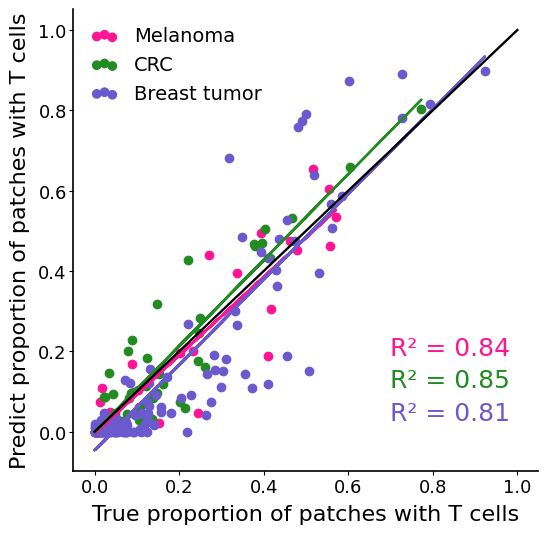

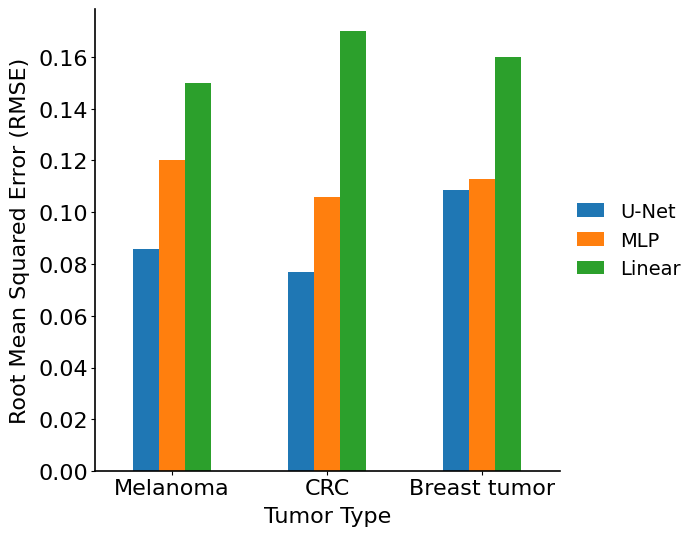

In [4]:
all_pred = {}
all_rmse = {}
thresholds = {}
for name, data in {
    "Melanoma": mla_data,
    "CRC": crc_data,
    "Breast tumor": bst_data,
}.items():
    thresh = mp.optimize_threshold(data, split="validate")
    pred, rmse = get_rmse_and_prediction(data, split="test", classify_threshold=thresh)
    print(f"{name} RMSE: {rmse}")
    all_pred[name] = pred
    all_rmse[name] = rmse
    thresholds[name] = thresh

plot_prediction_scatterplot(all_pred) #Figure 2C
plot_rmse(all_rmse) #Figure 2D

## 1. Visualizing patient-level perturbations

In [5]:
# import relevant functions
from analysis_helper import retrieve_perturbation
from figure_helper import plot_patient_perturbation

### Melanoma

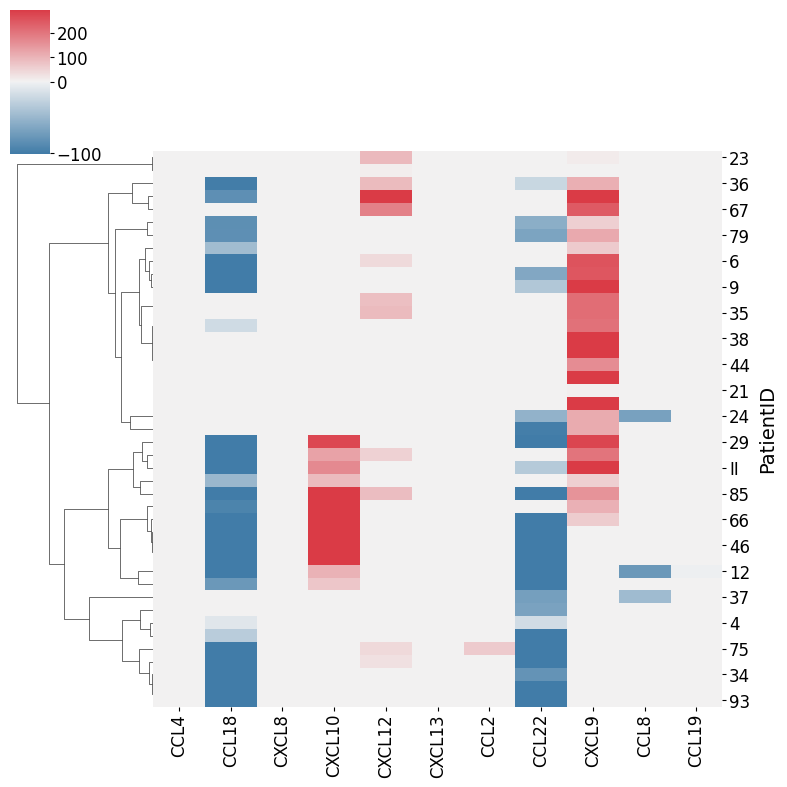

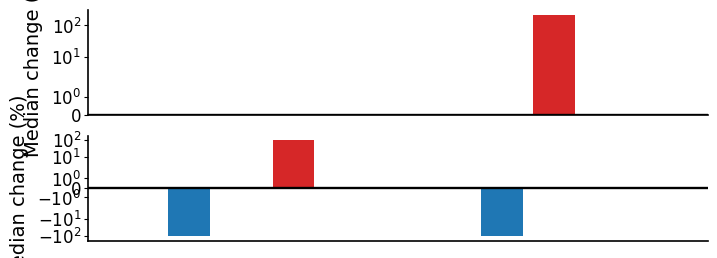

cluster  Cancer_Stage
1        IV              11
         III              7
         III or IV        1
         unknown          1
2        IV              11
         III              9
         unknown          1
Name: count, dtype: int64


,CCL4_mRNA,CCL18_mRNA,CXCL8_mRNA,CXCL10_mRNA,CXCL12_mRNA,CXCL13_mRNA,CCL2_mRNA,CCL22_mRNA,CXCL9_mRNA,CCL8_mRNA,CCL19_mRNA
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,214.568165,0.0,0.0
1,0.0,-100.000015,0.0,88.148949,0.0,0.0,0.0,-100.0,0.000000,0.0,0.0


In [6]:
cf_mla, channel_to_perturb_mla = retrieve_perturbation(
    mla_data, additional_col=["Cancer_Stage"]
)
strategy_mla, patient_cf_mla = plot_patient_perturbation(
    mla_data,
    cf_mla,
    channel_to_perturb_mla,
    numClust=3,
    extra_cols=["Cancer_Stage"],
    keep_top_2=True,
) #Figure 3A
display(strategy_mla)

### CRC

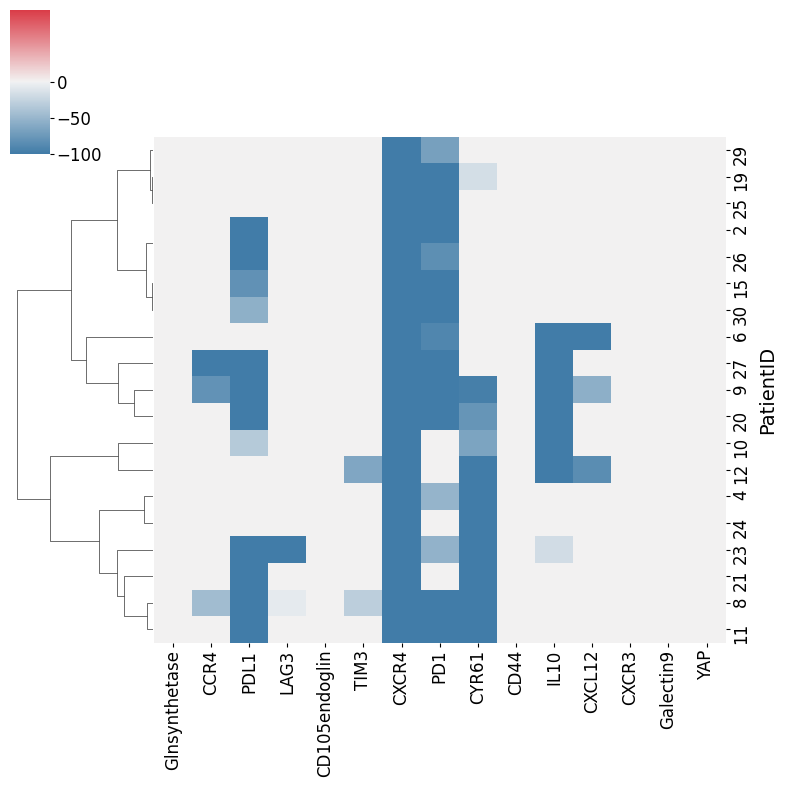

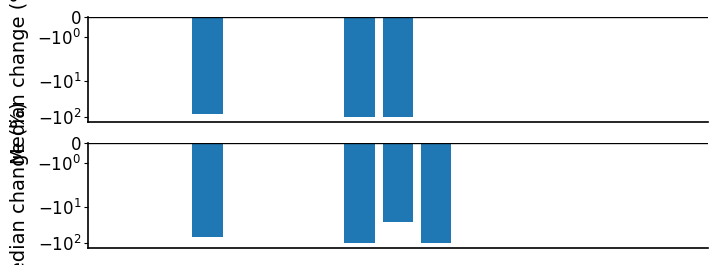

cluster  FLD
1        1.0    4
         0.0    3
         2.0    2
         3.0    2
2        0.0    7
         3.0    1
Name: count, dtype: int64


,Glnsynthetase,CCR4,PDL1,LAG3,CD105endoglin,TIM3,CXCR4,PD1,CYR61,CD44,IL10,CXCL12,CXCR3,Galectin9,YAP
0,0.0,0.0,-81.967278,0.0,0.0,0.0,-100.0,-100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-67.016325,0.0,0.0,0.0,-100.0,-25.793957,-100.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
cf_crc, channel_to_perturb_crc = retrieve_perturbation(
    crc_data, additional_col=["type", "FLD"]
)
strategy_crc, patient_cf_crc = plot_patient_perturbation(
    crc_data,
    cf_crc,
    channel_to_perturb_crc,
    numClust=2,
    extra_cols=["FLD"],
) #Figure 4A
display(strategy_crc)

## 2. Assess effectiveness of perturbation on test cohort

In [8]:
# import relevant functions
from analysis_helper import assess_perturbation
from figure_helper import plot_perturbation_performance

### Melanoma

original (predicted) = 0.204
original (true) = 0.217
strategy_1= 0.498
strategy_2= 0.417


/central/home/zwang2/morpheus-spatial/morpheus/reproduction/figure_helper.py:382: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcell_level_patient["true_orig_q1"] = (
/central/home/zwang2/morpheus-spatial/morpheus/reproduction/figure_helper.py:385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcell_level_patient["true_orig_q3"] = (
/central/home/zwang2/morpheus-spatial/morpheus/reproduction/figure_helper.py:390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

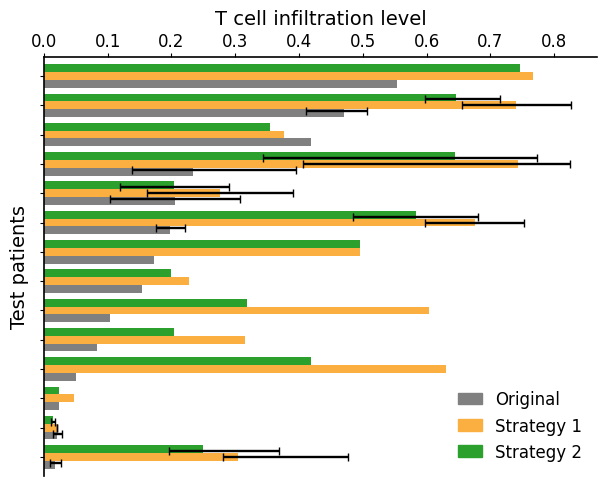

In [9]:
tcell_level_melanoma = assess_perturbation(
    mla_data,
    strategy_mla,
    data_split="test",
    classify_threshold=thresholds["Melanoma"],
    additional_col=["Cancer_Stage"],
)

plot_perturbation_performance(
    tcell_level_melanoma,
) #Figure 3H

### CRC

original (predicted) = 0.200
original (true) = 0.186
strategy_1= 0.346
strategy_2= 0.344


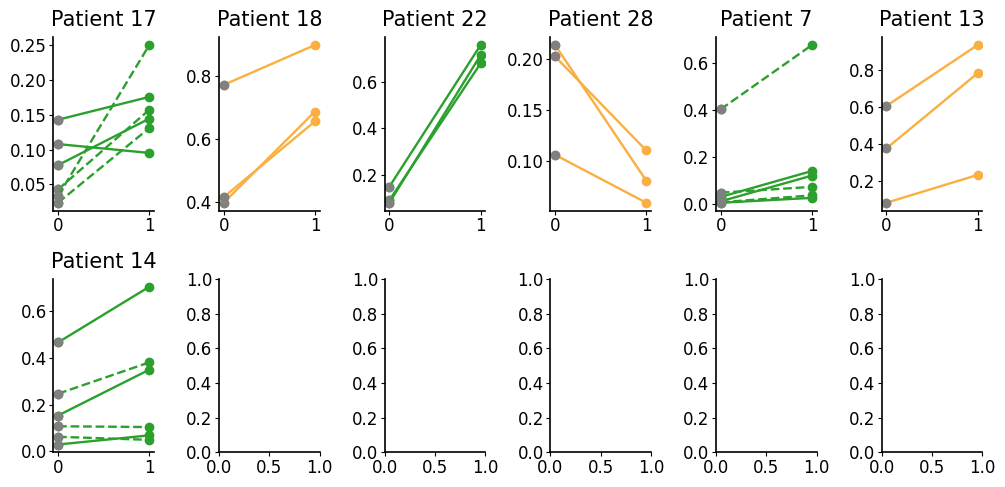

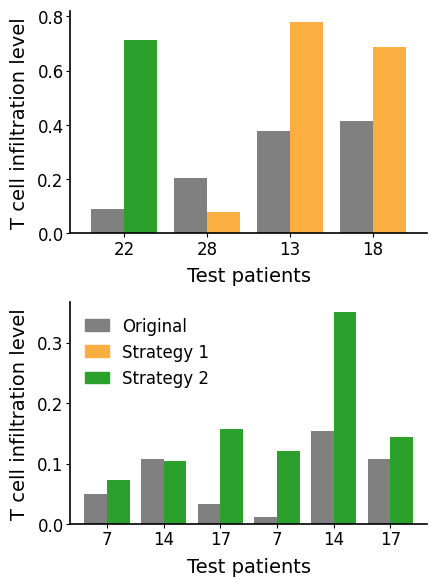

In [10]:
tcell_level_crc = assess_perturbation(
    crc_data,
    strategy_crc,
    data_split="test",
    classify_threshold=thresholds["CRC"],
    additional_col=["FLD", "type"],
)

tcell_level_crc["FLD"] = tcell_level_crc.apply(
    lambda x: 1 if x["FLD"] > 0 else 0, axis=1
)

plot_perturbation_performance(
    tcell_level_crc,
    patient_phenotype="FLD",
    strategy_mapping={"strategy_1": 1, "strategy_2": 0},
) #Figure 4G

## 3. Visualizing perturbation vectors in UMAP space

In [11]:
from analysis_helper import get_umap_embeddings
from figure_helper import plot_umap_embedding, plot_umap_embedding_crc

### Melanoma

Loading counterfactuals
number of invalid rows removed: 0
Fitting UMAP model


/central/home/zwang2/.cache/pypoetry/virtualenvs/morpheus-spatial-ndDQRg-x-py3.9/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Computing UMAP embeddings


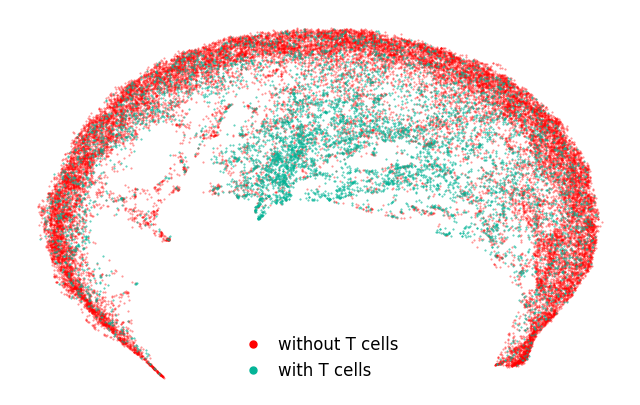

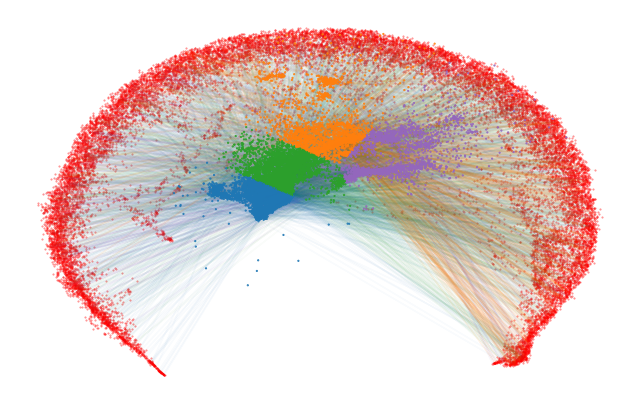

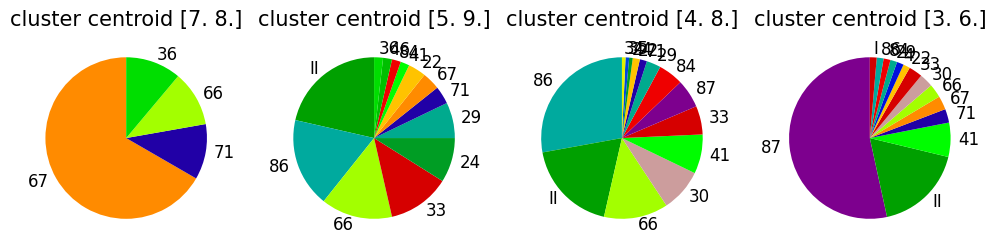

In [12]:
embedding_mla, umap_cf_mla = get_umap_embeddings(
    mla_data, cf_mla, channel_to_perturb_mla
)
plot_umap_embedding(embedding_mla, umap_cf_mla, pie_chart=True) #Figure 3F

### CRC

Loading counterfactuals
number of invalid rows removed: 0
Fitting UMAP model


/central/home/zwang2/.cache/pypoetry/virtualenvs/morpheus-spatial-ndDQRg-x-py3.9/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Computing UMAP embeddings


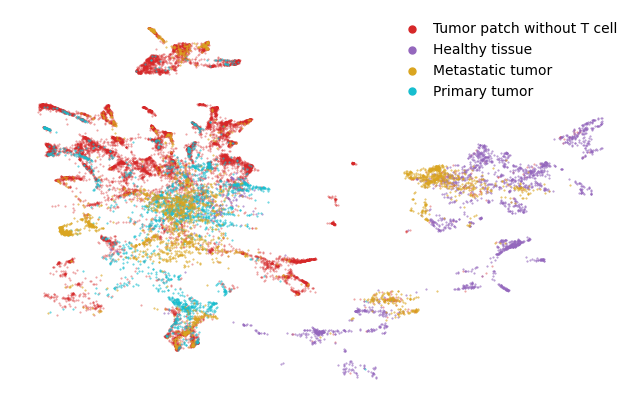

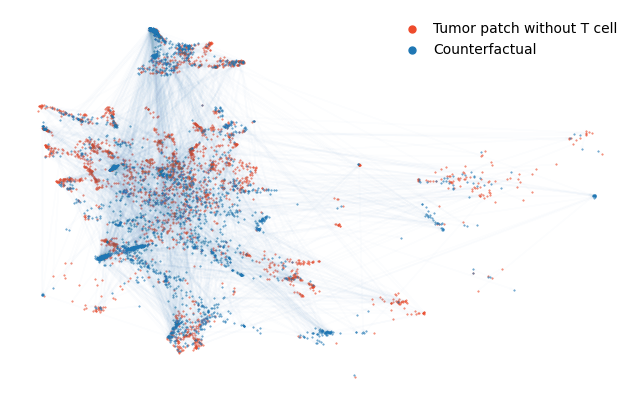

In [13]:
embedding_crc, umap_cf_crc = get_umap_embeddings(
    crc_data, cf_crc, channel_to_perturb_crc, additional_col=["type"]
)
plot_umap_embedding_crc(embedding_crc, umap_cf_crc) #Figure 4F

## 4. Comparing patients across clusters with volcano plots

In [14]:
from analysis_helper import differential_analysis_celltype, differential_analysis_genes
from figure_helper import make_volcano_plot

### Melanoma

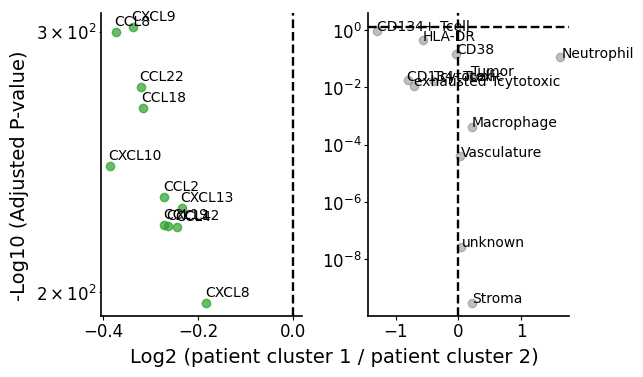

In [15]:
mla_celltype_da = differential_analysis_celltype(mla_data, patient_cf_mla)
mla_genes_da = differential_analysis_genes(
    mla_data, patient_cf_mla, channel_to_perturb_mla
)
make_volcano_plot(mla_genes_da, mla_celltype_da) #Figure 3C

### CRC

/central/home/zwang2/morpheus-spatial/morpheus/reproduction/analysis_helper.py:411: RuntimeWarning: divide by zero encountered in scalar divide
  fold_change = np.mean(val_to_compare[1]) / np.mean(val_to_compare[2])
/central/home/zwang2/.cache/pypoetry/virtualenvs/morpheus-spatial-ndDQRg-x-py3.9/lib64/python3.9/site-packages/matplotlib/transforms.py:354: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
posx and posy should be finite values
posx and posy should be finite values


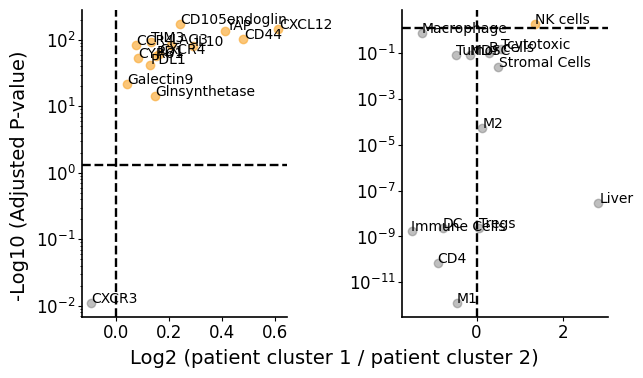

In [16]:
crc_celltype_da = differential_analysis_celltype(crc_data, patient_cf_crc)
crc_genes_da = differential_analysis_genes(
    crc_data, patient_cf_crc, channel_to_perturb_crc
)
make_volcano_plot(crc_genes_da, crc_celltype_da) #Figure 4D

## 5. Tissue-level perturbation heatmap (CRC only)

In [17]:
from figure_helper import plot_tissue_level_perturbation

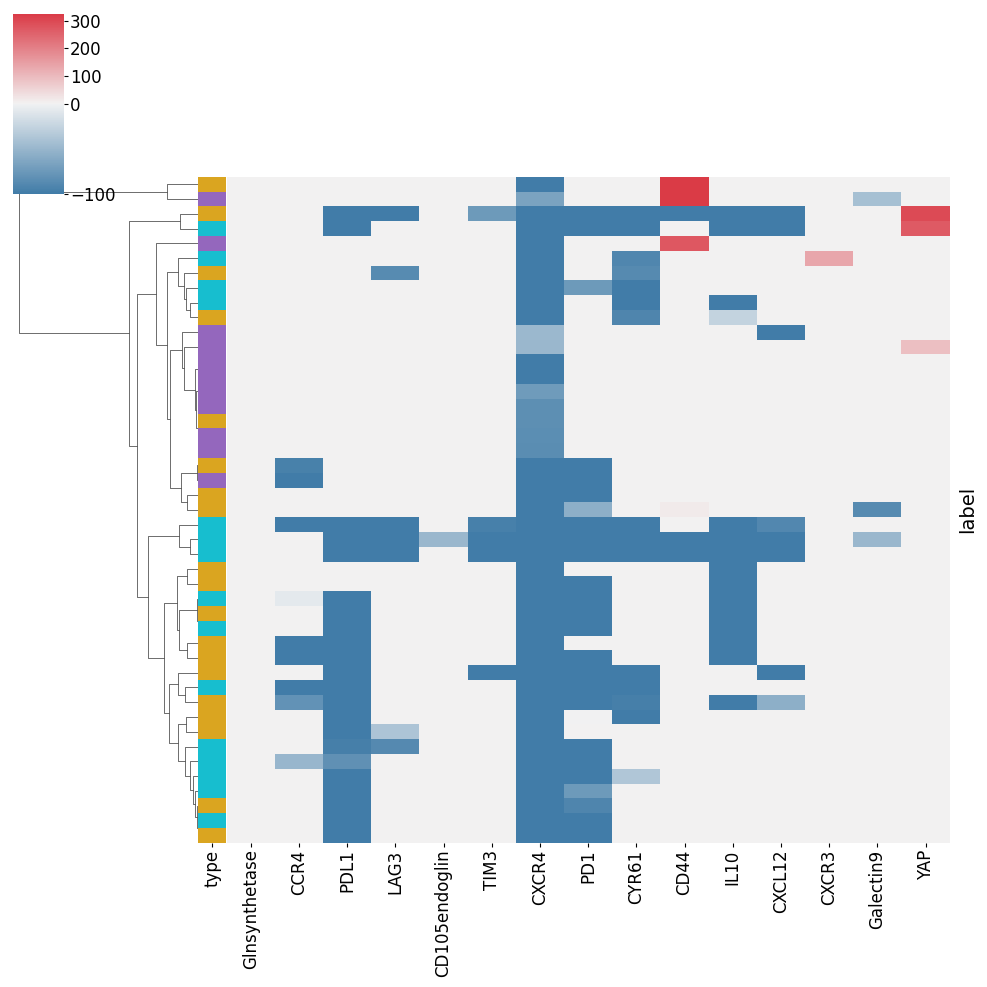

In [18]:
plot_tissue_level_perturbation(cf_crc, channel_to_perturb_crc) #Figure 4E

## 6. Patch-level perturbation heatmap (Melanoma only)

In [19]:
from analysis_helper import get_IHC_subset
from figure_helper import make_patch_heatmap_mla

2471


/central/home/zwang2/.cache/pypoetry/virtualenvs/morpheus-spatial-ndDQRg-x-py3.9/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


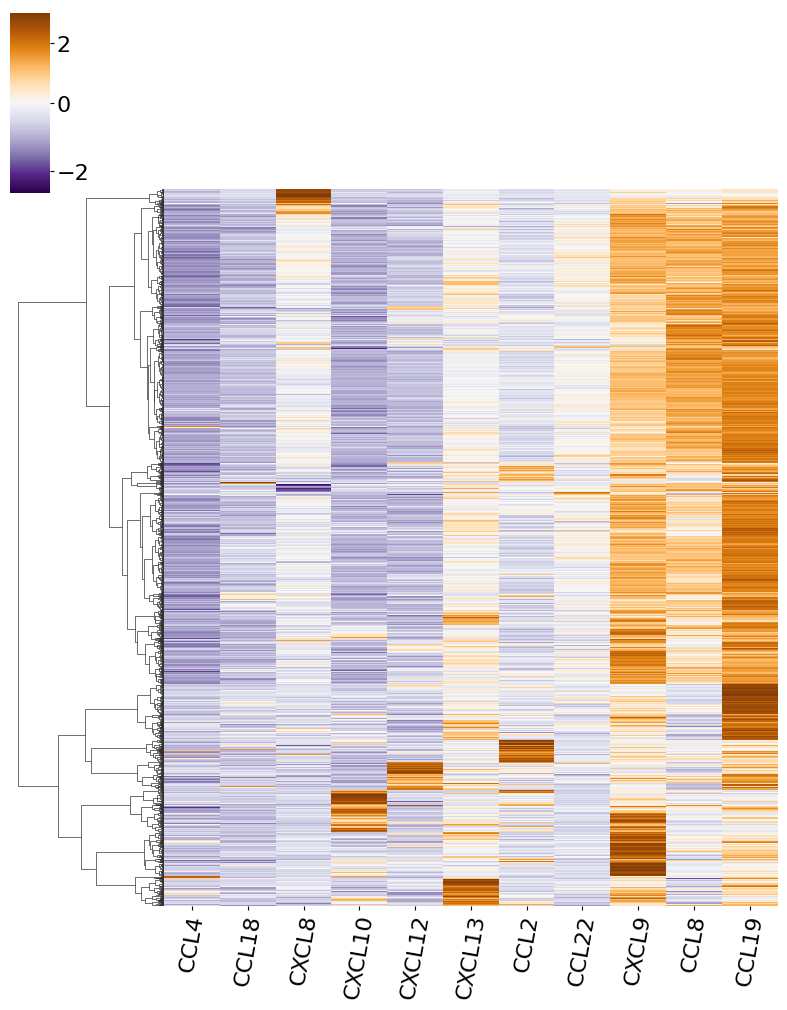

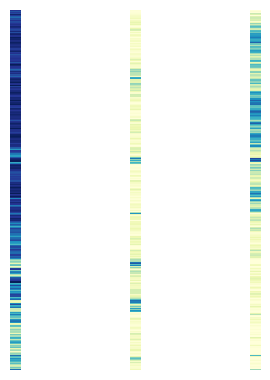

In [20]:
X, label = get_IHC_subset(mla_data, channel_to_perturb_mla)
make_patch_heatmap_mla(X, label) #Figure 3D

## 7. Strategy of varying sparsity

In [21]:
from analysis_helper import assess_perturbation
from figure_helper import make_multi_strat_plot
import pandas as pd

### CRC

original (predicted) = 0.200
original (true) = 0.186
strategy_1= 0.287
strategy_2= 0.314
strategy_3= 0.333
strategy_4= 0.370
strategy_5= 0.394


/central/home/zwang2/.cache/pypoetry/virtualenvs/morpheus-spatial-ndDQRg-x-py3.9/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


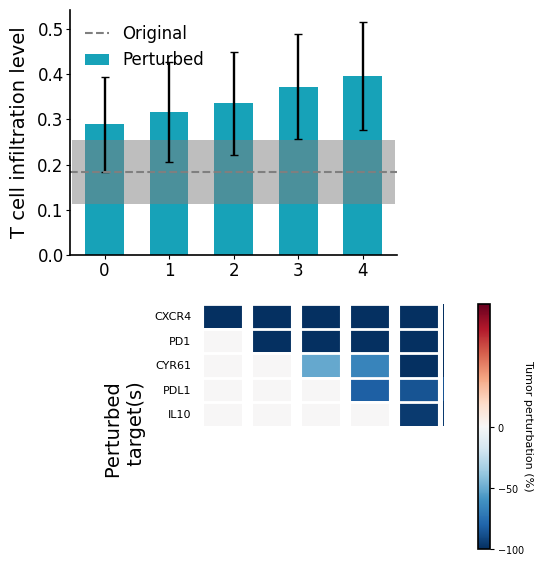

In [23]:
allStrategy = pd.read_csv("crc_output/allstrat.csv")
tcell_crc = assess_perturbation(
    crc_data,
    allStrategy,
    data_split="test",
    classify_threshold=thresholds['CRC'],
    additional_col=["FLD", "type"],
)
infiltrate_lower, infiltrate_upper = make_multi_strat_plot(
    allStrategy,
    tcell_crc,
    chemlabel=["CXCR4", "PD1", "CYR61", "PDL1", "IL10"]
) #Figure 4H

### Melanoma

original (predicted) = 0.204
original (true) = 0.217
strategy_1= 0.369
strategy_2= 0.426
strategy_3= 0.548
strategy_4= 0.626
strategy_5= 0.634


/central/home/zwang2/.cache/pypoetry/virtualenvs/morpheus-spatial-ndDQRg-x-py3.9/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


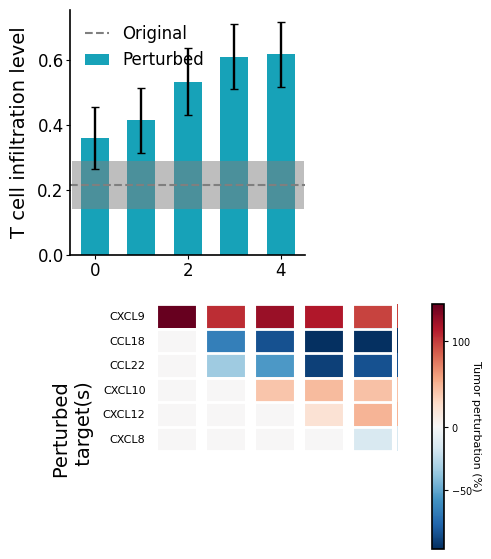

In [24]:
allStrategy = pd.read_csv("melanoma_output/allstrat.csv")
tcell_mla = assess_perturbation(
    mla_data,
    allStrategy,
    data_split="test",
    classify_threshold=thresholds['Melanoma'],
)
infiltrate_lower, infiltrate_upper = make_multi_strat_plot(
    allStrategy,
    tcell_mla,
    chemlabel=["CXCL9", "CCL18", "CCL22", "CXCL10", "CXCL12", "CXCL8"]
) #Figure 3I

## 8. Correlation plots

In [25]:
from analysis_helper import get_feature_correlation
from figure_helper import plot_correlation

### Melanoma

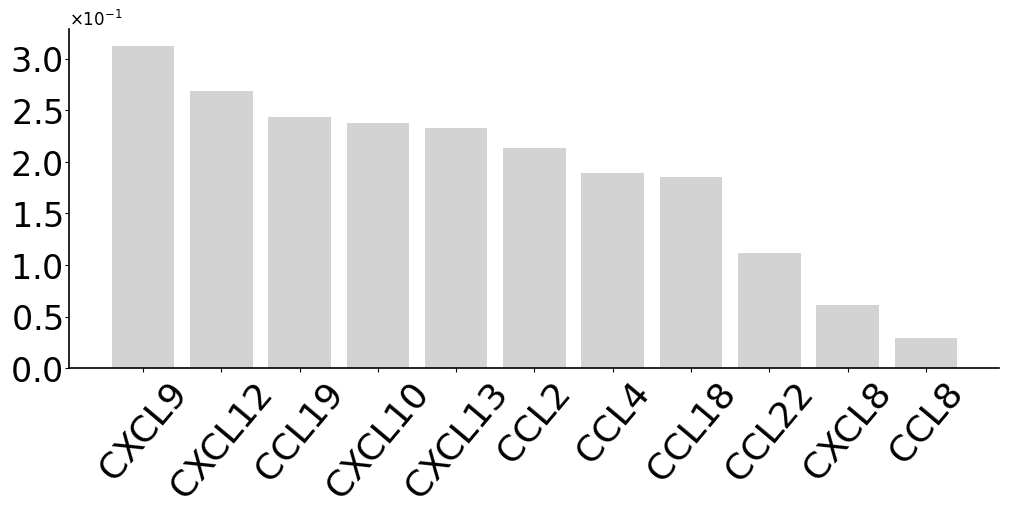

In [26]:
corr_mla = get_feature_correlation(mla_data, channel_to_perturb_mla)
plot_correlation(corr_mla) #Figure 3E

### CRC

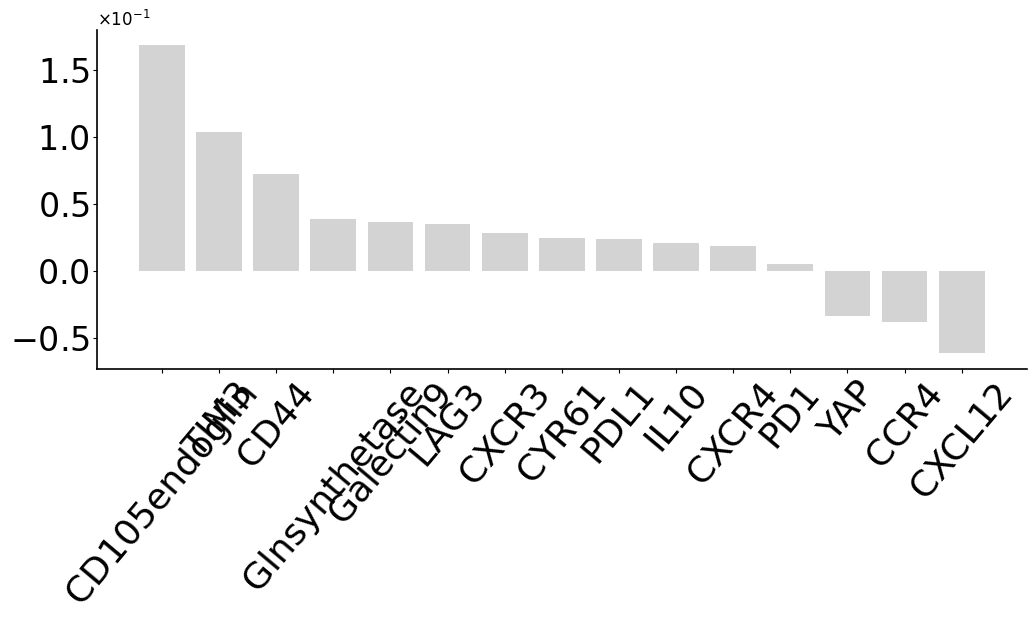

In [27]:
corr_crc = get_feature_correlation(crc_data, channel_to_perturb_crc)
plot_correlation(corr_crc) #Figure 4B

## 9. T cell map

In [28]:
from figure_helper import get_example_Tcell_map, make_multiple_Tcell_map

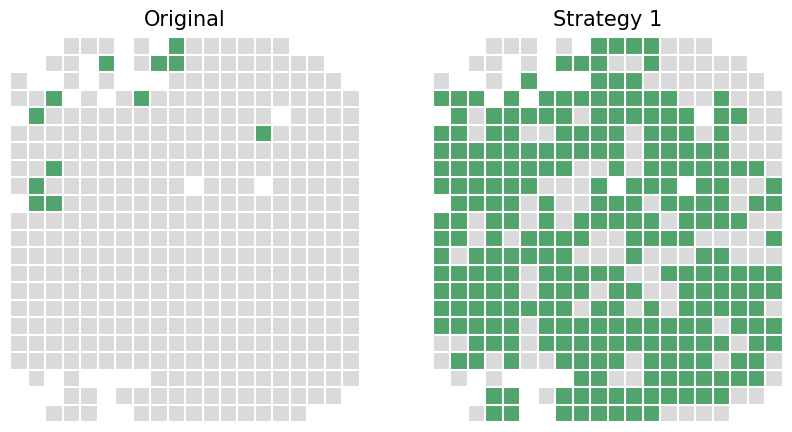

/central/home/zwang2/morpheus-spatial/morpheus/reproduction/figure_helper.py:1575: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_metadata["pred_orig"] = model(X) > threshold


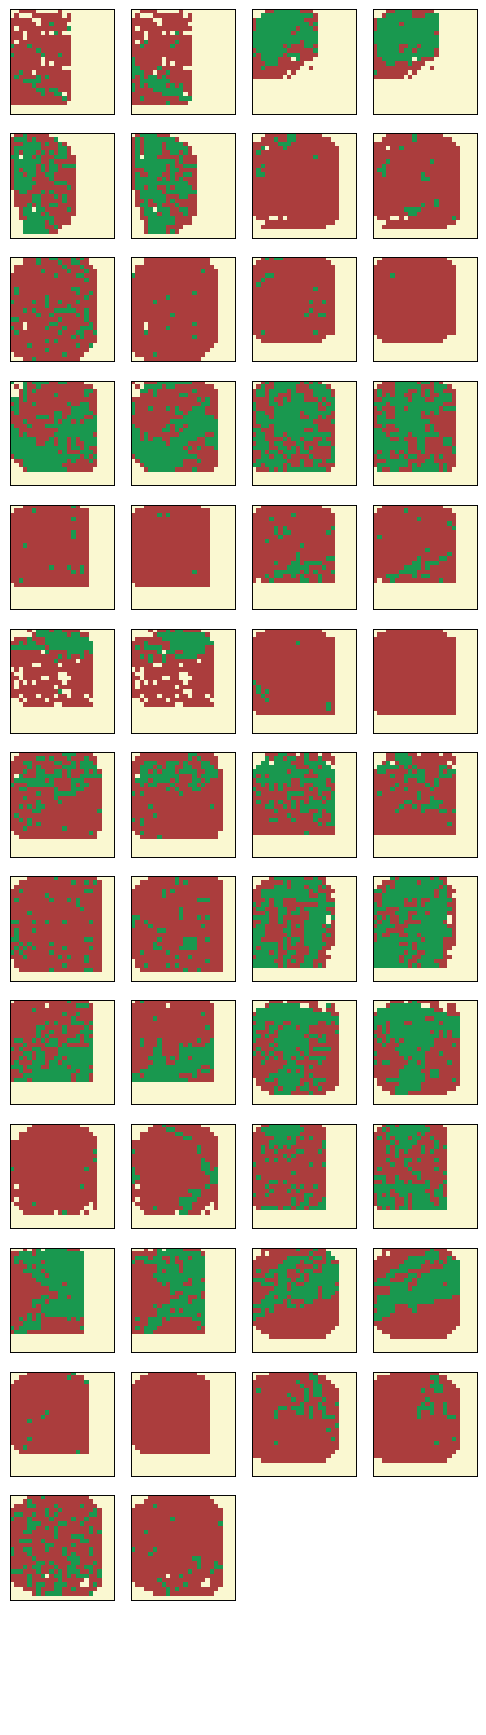

/central/home/zwang2/morpheus-spatial/morpheus/reproduction/figure_helper.py:1575: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_metadata["pred_orig"] = model(X) > threshold


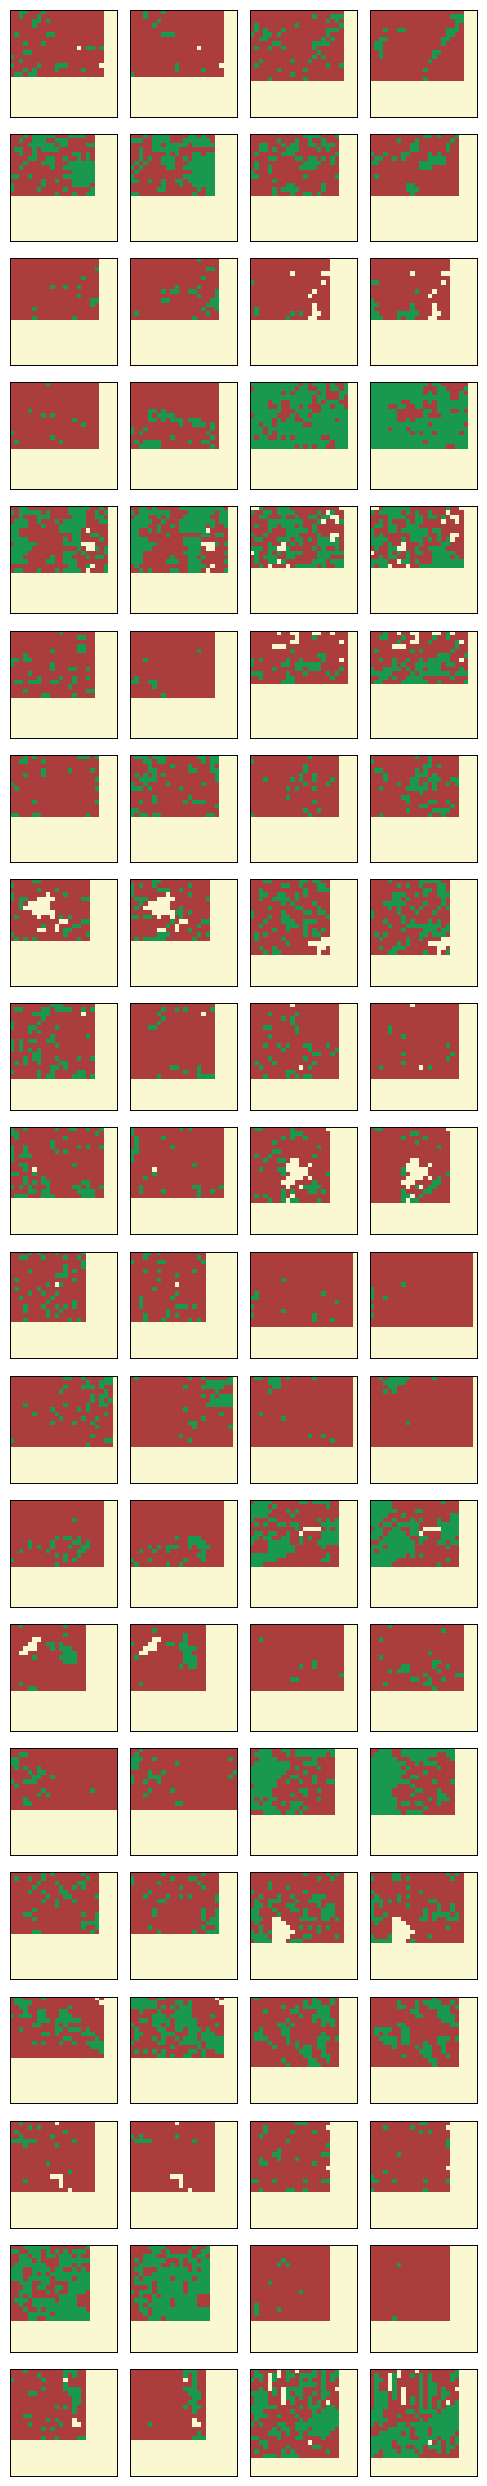

/central/home/zwang2/morpheus-spatial/morpheus/reproduction/figure_helper.py:1575: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_metadata["pred_orig"] = model(X) > threshold


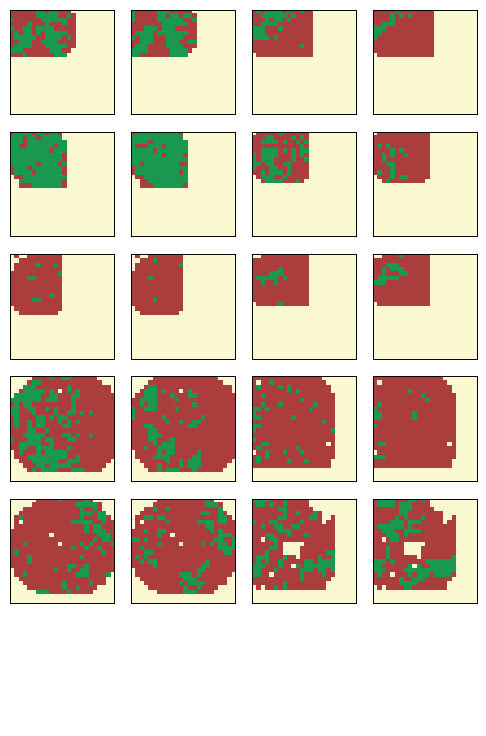

In [29]:
# single tissue slice
get_example_Tcell_map(mla_data, tcell_level_melanoma, img=23) #Figure 3G

# all (large) test cohort tissue slice, Figure 2B
make_multiple_Tcell_map(mla_data, thresholds['Melanoma'])
make_multiple_Tcell_map(crc_data, thresholds['CRC']) 
make_multiple_Tcell_map(bst_data, thresholds['Breast tumor'])